# Keldy: Playground

## Imports & Setup Properties

In [1]:
import os
import sys
import glob
import copy
import itertools

import h5py

import math
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import scipy.integrate


In [2]:
import mpi4py
import mpi4py.MPI

In [3]:
# sys.path

### Plotting

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

In [5]:
#Plotting Options
markslist='o^v<>dhps*HD'
cmap = plt.get_cmap('plasma')
color_list_limit = 2

def f_colorlist(i, offset = 0, cycle = color_list_limit):
    return cmap(float((i+offset)%cycle) / cycle)

def f_markslist(i, offset = 0, cycle = color_list_limit):
    return markslist[((i+offset)%cycle)]

### Keldy Import

In [6]:
from pytriqs.gf import *
from pytriqs.plot.mpl_interface import oplot,plt

import keldy.impurity_oneband_module as k_imp

## Model g0

In [7]:
# anderson_param = {
#     "beta": 10000.0, 
#     "bias_V" : 0.0,
#     "eps_d": -0.5,
#     "Gamma": 0.25,
#     "time_max": 100.0,
#     "alpha": -0.0,
#     "nr_time_points_gf": int(2*5000-1),#int(1e6),
#     "bath_type": "semicircle"
# }

anderson_param_A1 = {
    "beta": 1e5, 
    "bias_V" : 0.0,
    "eps_d": 0.0,
    "Gamma": 0.25,
    "time_max": 500.0,
    "alpha": 0.0,
    "nr_time_points_gf": 2 * int(1e6) - 1,#int(1e6),
    "bath_type": "semicircle"
}

anderson_param_A2 = {
    "beta": 1e5, 
    "bias_V" : 0.0,
    "eps_d": -0.5,
    "Gamma": 0.25,
    "time_max": 500.0,
    "alpha": 0.0,
    "nr_time_points_gf": 2 * int(1e6) - 1,#int(1e6),
    "bath_type": "semicircle"
}

In [8]:
# g0 = k_imp.G0Model(anderson_param)

In [9]:
oplot(g0.g0_greater, '-', linewidth=2, x_window=(-15,15)) 

NameError: name 'g0' is not defined

In [10]:
oplot(g0.g0_lesser, '-', linewidth=2, x_window=(-15,15)) 

NameError: name 'g0' is not defined

### Keldysh Adaptor

In [14]:
g0K = k_imp.G0KeldyshContourT(g0)

In [15]:
g0K.model.param_['alpha']

-0.0

In [16]:
# t

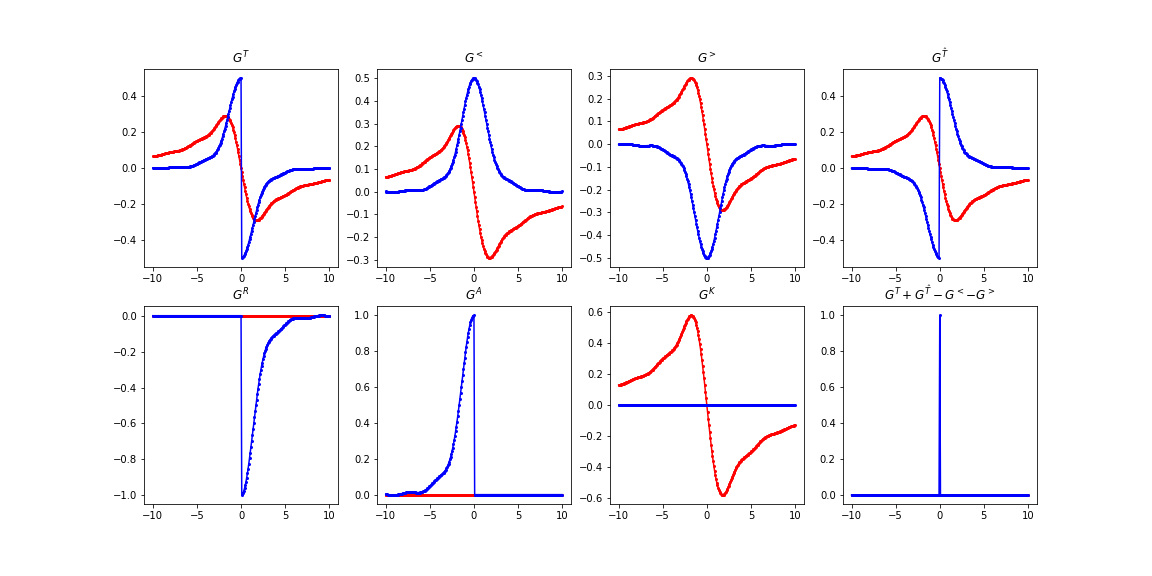

In [17]:
fig = plt.figure(figsize=(16,8))

t = np.linspace(-10,10,251)

g_ff = np.zeros(len(t), dtype='c16')
g_fb = np.zeros(len(t), dtype='c16')
g_bf = np.zeros(len(t), dtype='c16')
g_bb = np.zeros(len(t), dtype='c16')
gR = np.zeros(len(t), dtype='c16')
gA = np.zeros(len(t), dtype='c16')
gK = np.zeros(len(t), dtype='c16')
g_cancel = np.zeros(len(t), dtype='c16')

for i in range(len(t)):
    g_ff[i]  = g0K(k_imp.GfIndexT(t[i], 0, 0, 0), k_imp.GfIndexT(0, 0, 0, 0)) 
    g_fb[i]  = g0K(k_imp.GfIndexT(t[i], 0, 0, 0), k_imp.GfIndexT(0, 0, 1, 0)) 
    g_bf[i]  = g0K(k_imp.GfIndexT(t[i], 0, 1, 0), k_imp.GfIndexT(0, 0, 0, 0)) 
    g_bb[i]  = g0K(k_imp.GfIndexT(t[i], 0, 1, 0), k_imp.GfIndexT(0, 0, 1, 0)) 

    gR[i]  = g_ff[i] - g_fb[i]
    gA[i]  = g_ff[i] - g_bf[i]
    gK[i]  = g_fb[i] + g_bf[i]
    
    g_cancel[i] = g_ff[i] + g_bb[i] - g_bf[i] - g_fb[i]

plt_list = [(g_ff, "$G^T$"), (g_fb, "$G^<$"), (g_bf, "$G^>$"), (g_bb, r"$G^{\hat{T}}$"), (gR, "$G^R$"), (gA, "$G^A$"), (gK, "$G^K$"), (g_cancel, "$G^T + G^{\hat{T}} - G^< - G^>$")]
for (i_p, (fun, label)) in enumerate(plt_list):
    ax0 = plt.subplot(2,4,i_p + 1)
    ax0.plot(t, fun.real, marker='o', markersize=2, color='red')
    ax0.plot(t, fun.imag, marker='o', markersize=2, color='blue')
    ax0.set_title(label)
#     ax0.set_scale.
# plt.savefig("ph-symm-gf.pdf")
plt.show()

## Measurement

In [11]:
order = 1
t_max = 10.0
computer = k_imp.ComputeChargeQDirect(anderson_param_A2, t_max, order, 'lorentzian', int(1e5))
N_tot = 0

In [12]:
integrand = computer.get_integrand()
warper = computer.get_warper()

In [23]:
result = []
N_vec = []

currN = 0

In [24]:
for i in range(1000):
    step = 1
    computer.run(step)
    currN += step
    result.append((-1j)*(-1j)**order * computer.reduce_result() )
    N_vec.append(currN)

In [25]:
currN

1000

In [53]:
result

[]

In [148]:
1+1

2

In [117]:
np.array(result).real[-1]

-0.16471493664181

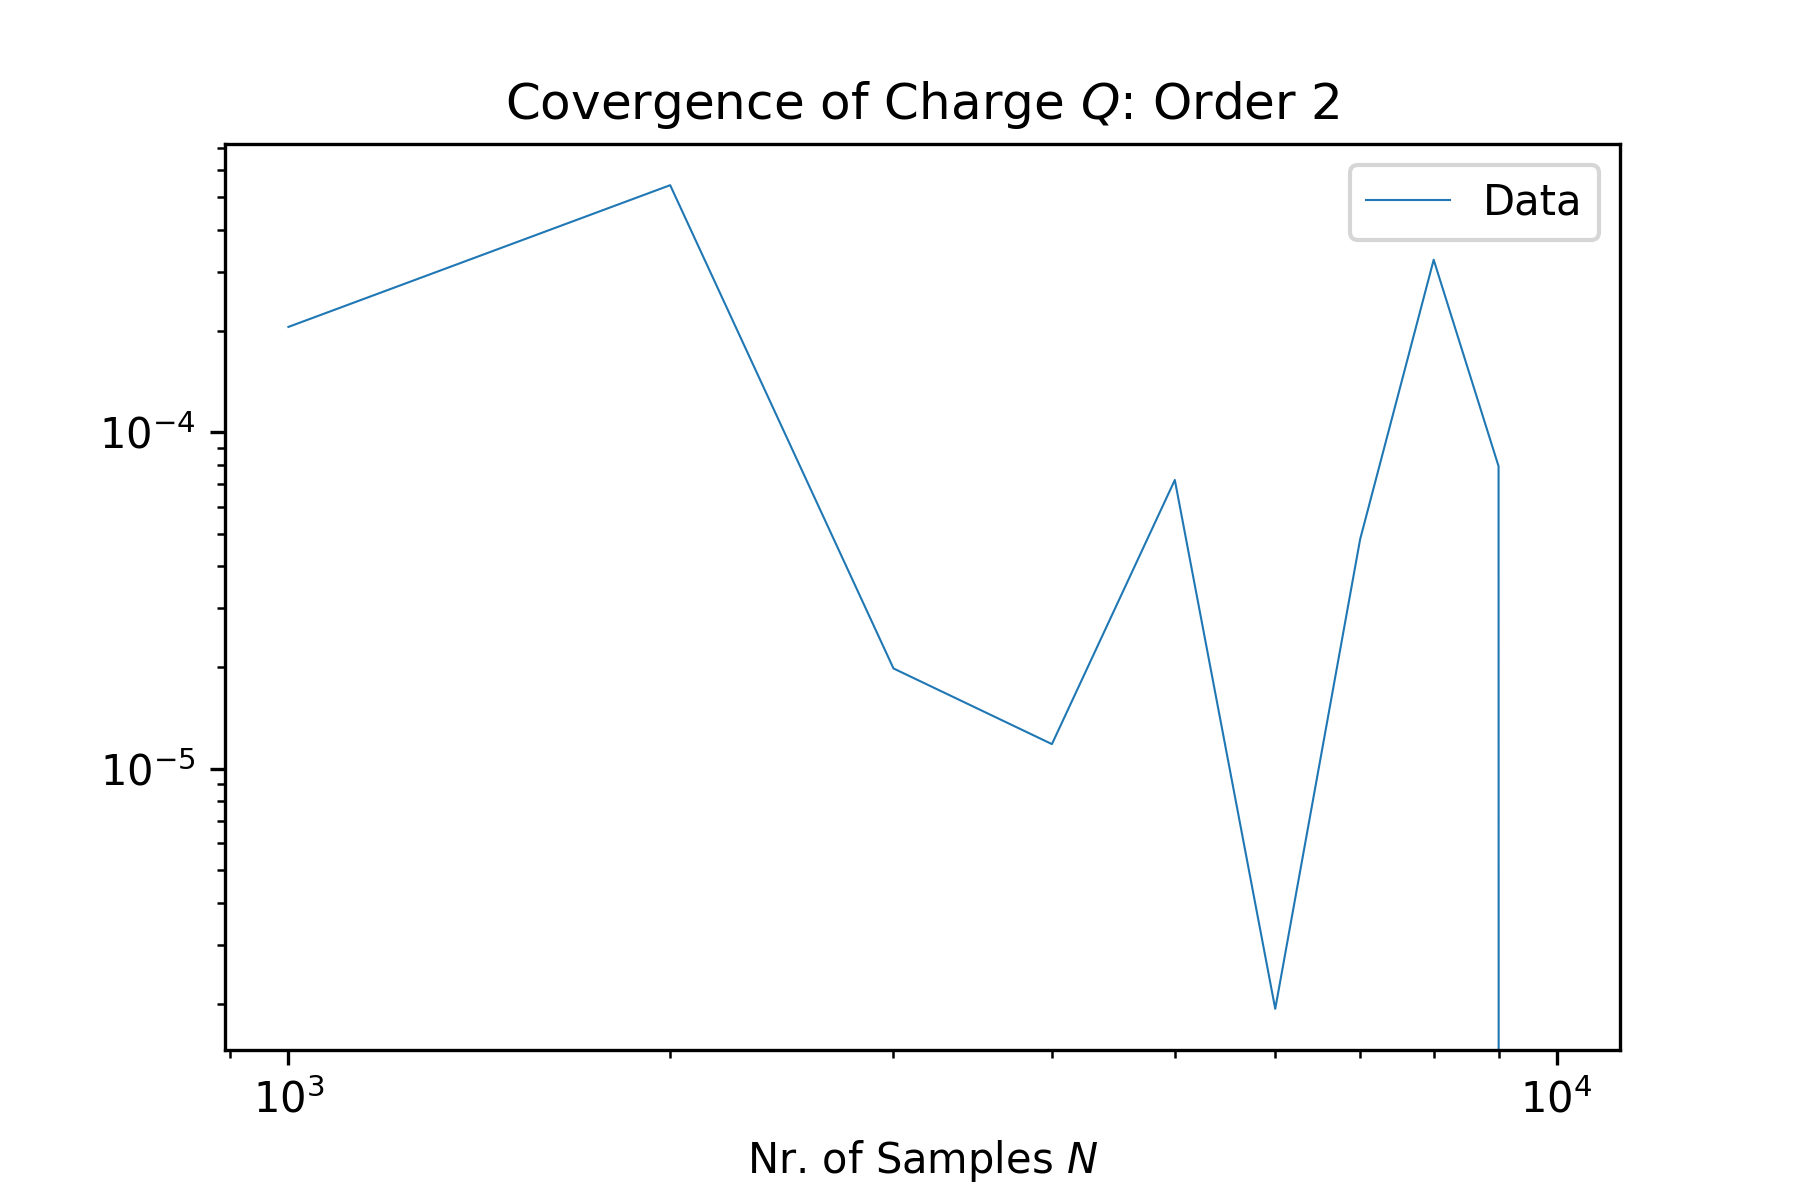

In [118]:
fig = plt.figure(dpi=300)
ax0 = plt.axes()


ax0.plot(N_vec, np.abs(np.array(result).real - np.array(result).real[-1] ), linewidth=0.5, label="Data")

logscale_x = np.array([10**3, 10**7])
logscale_y1 = np.array([10**-3, 10**-7])


# ax0.plot(logscale_x, logscale_y1 * 100, c='red', label="$N^{-1}$")
# ax0.plot(logscale_x, np.sqrt(logscale_y1)  *3, c='k', label="$N^{-1/2}$")

ax0.set_xscale('log')
ax0.set_yscale('log')

ax0.set_title(r"Covergence of Charge $Q$: Order {}".format(order))
ax0.set_xlabel("Nr. of Samples $N$")

ax0.legend()
# plt.tight_layout()
# plt.savefig(save_name + "_krylov_normalization.pdf", dpi=600)
plt.show()
plt.close()

In [43]:
(-1j)*(-1j)**order * computer.reduce_result() 

(0.2850061020283006-8.6582114759719e-13j)

In [44]:
computer.reduce_nr_points_run() 

500000

In [45]:
result_1 = 0.37803751573267336
result_2 = 0.285251918462279

## Compare to Marjan

In [10]:
g0 = k_imp.G0Model(anderson_param_A2)
g0K = k_imp.G0KeldyshContourT(g0)

In [11]:
g0.g0_greater["up"](1.0)

(-0.05098666668844833-0.080016436685713j)

In [14]:
g0.g0_greater.mesh

Linear Mesh of size 1999999

### Sobol Generator

In [49]:
order_dim = 2

In [50]:
rng = k_imp.Sobol(order_dim, 0)

In [51]:
rng.seed(0)

In [14]:
integrand([9, 8])

(-7.827488657241588e-12+0.013313176919940883j)

In [86]:
g_d1(k_imp.GfIndexT(10, 0, 1), k_imp.GfIndexT(10, 0, 0), 9)

(-0.11034281308472933-3.23866003459905e-11j)

In [66]:
rng.seed(0)
for i in range(20):
    li = rng()
    ui = warper.ui_from_li(li)
    print(ui)
    
    integrand_eval = integrand(ui)
        
    print(li, integrand_eval)



[9.16666666666766, 8.333333333335322]
([0.5, 0.5], (-1.0241252290654757e-11+0.033202491054353356j))
[7.857142857144513, 7.563025210085904]
([0.75, 0.25], (-3.976203394318034e-11+0.08015134555912495j))
[9.70588235294139, 7.563025210085904]
([0.25, 0.75], (-1.1953354972504826e-12+0.002147017535562068j))
[9.482758620690205, 8.965517241380411]
([0.375, 0.375], (-1.6155368709469542e-11+0.031996272196851305j))
[6.111111111111356, 2.222222222222712]
([0.875, 0.875], (2.0795743599366645e-12-0.0060473916886436j))
[8.684210526317145, 8.556005398112104]
([0.625, 0.125], (-4.44681236277944e-11+0.08955968462576225j))
[9.87179487179496, 8.556005398112102]
([0.125, 0.625], (-8.882478086391643e-13+0.0015985983870585585j))
[9.794520547945355, 9.397695151120269]
([0.1875, 0.3125], (-7.647230071405886e-12+0.015143557063486357j))
[8.333333333335391, 5.5072463768159245]
([0.6875, 0.8125], (-1.7122414597281477e-12+0.0035073439204104107j))
[4.230769230770688, 4.170528266915307]
([0.9375, 0.0625], (-1.0281001

In [35]:
rng.seed(0)
for i in range(23):
    li = rng()
    ui = warper.ui_from_li(li)
    vi = k_imp.vi_from_ui(t_max, ui)
    
    ui_m = np.array(ProfumaA1_Semicircle)[i,8:12]
    
#     print( li, ui, np.sort(np.array(ProfumaA1_Semicircle)[i,8:12]))
#     print( li, vi, np.array(ProfumaA1_Semicircle)[i,4:8])
    
    integrand_eval = integrand(ui_m)
    print(li, integrand_eval.real - np.array(ProfumaA1_Semicircle)[i,12] *  np.array(ProfumaA1_Semicircle)[i,13])#, integrand_eval.imag - np.array(ProfumaA1_Semicircle)[i,12] *  np.array(ProfumaA1_Semicircle)[i,14])
#     warper_eval = warper.evaluate_warping_function(ui_m)
#     print(li, np.array(ProfumaA1_Semicircle)[i,15] / warper_eval)



    

NameError: name 'ProfumaA1_Semicircle' is not defined

In [89]:
ProfumoA1_Semicircle = np.genfromtxt("/Users/pdumitrescu/Documents/machine-learning-marjan2019/Data/ProfumoMethod/ProfumoA1_DataPoints.dat")

In [90]:
ProfumaA1_Semicircle[1,:]

NameError: name 'ProfumaA1_Semicircle' is not defined

0j

In [85]:
def g_d1(kI1, kI2, ti1):
    k_ti1_u_p = k_imp.GfIndexT(ti1, 0, 0)
    k_ti1_u_m = k_imp.GfIndexT(ti1, 0, 1)
    k_ti1_d_p = k_imp.GfIndexT(ti1, 1, 0)
    k_ti1_d_m = k_imp.GfIndexT(ti1, 1, 1)

    diag1 = - (-1) * g0K(kI1, k_ti1_u_m, True) * g0K(k_ti1_u_m, kI2, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) 
    diag2 = - (+1) * g0K(kI1, k_ti1_u_p, True) * g0K(k_ti1_u_p, kI2, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) 
    return  (diag1 + diag2)

def g_d2(kI1, kI2, ti1, ti2):
    k_ti1_u_p = k_imp.GfIndexT(ti1, 0, 0)
    k_ti1_u_m = k_imp.GfIndexT(ti1, 0, 1)
    k_ti1_d_p = k_imp.GfIndexT(ti1, 1, 0)
    k_ti1_d_m = k_imp.GfIndexT(ti1, 1, 1)

    k_ti2_u_p = k_imp.GfIndexT(ti2, 0, 0)
    k_ti2_u_m = k_imp.GfIndexT(ti2, 0, 1)
    k_ti2_d_p = k_imp.GfIndexT(ti2, 1, 0)
    k_ti2_d_m = k_imp.GfIndexT(ti2, 1, 1)


    diag1a = (-1)**2 * (g0K(kI1, k_ti1_u_m, True) * g0K(k_ti1_u_m, k_ti2_u_m, True) * g0K(k_ti2_u_m, kI2, True)) * ( g0K(k_ti1_d_m, k_ti1_d_m, True) * g0K(k_ti2_d_m, k_ti2_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2a = (-1)**1 * (g0K(kI1, k_ti1_u_m, True) * g0K(k_ti1_u_m, k_ti2_u_p, True) * g0K(k_ti2_u_p, kI2, True)) * ( g0K(k_ti1_d_m, k_ti1_d_m, True) * g0K(k_ti2_d_p, k_ti2_d_p, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag3a = (-1)**1 * (g0K(kI1, k_ti1_u_p, True) * g0K(k_ti1_u_p, k_ti2_u_m, True) * g0K(k_ti2_u_m, kI2, True)) * ( g0K(k_ti1_d_p, k_ti1_d_p, True) * g0K(k_ti2_d_m, k_ti2_d_m, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag4a = (-1)**0 * (g0K(kI1, k_ti1_u_p, True) * g0K(k_ti1_u_p, k_ti2_u_p, True) * g0K(k_ti2_u_p, kI2, True)) * ( g0K(k_ti1_d_p, k_ti1_d_p, True) * g0K(k_ti2_d_p, k_ti2_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )
    
    diagA = (diag1a +  diag2a + diag3a + diag4a)
    
    diag1b = (-1)**2 * (g0K(kI1, k_ti2_u_m, True) * g0K(k_ti2_u_m, k_ti1_u_m, True) * g0K(k_ti1_u_m, kI2, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2b = (-1)**1 * (g0K(kI1, k_ti2_u_m, True) * g0K(k_ti2_u_m, k_ti1_u_p, True) * g0K(k_ti1_u_p, kI2, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag3b = (-1)**1 * (g0K(kI1, k_ti2_u_p, True) * g0K(k_ti2_u_p, k_ti1_u_m, True) * g0K(k_ti1_u_m, kI2, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag4b = (-1)**0 * (g0K(kI1, k_ti2_u_p, True) * g0K(k_ti2_u_p, k_ti1_u_p, True) * g0K(k_ti1_u_p, kI2, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )

    diagB = (diag1b +  diag2b + diag3b + diag4b)



    diag1c = - (-1)**2 * (g0K(kI1, kI2, True) * g0K(k_ti2_u_m, k_ti1_u_m, True) * g0K(k_ti1_u_m, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2c = - (-1)**1 * (g0K(kI1, kI2, True) * g0K(k_ti2_u_m, k_ti1_u_p, True) * g0K(k_ti1_u_p, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag3c = - (-1)**1 * (g0K(kI1, kI2, True) * g0K(k_ti2_u_p, k_ti1_u_m, True) * g0K(k_ti1_u_m, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag4c = - (-1)**0 * (g0K(kI1, kI2, True) * g0K(k_ti2_u_p, k_ti1_u_p, True) * g0K(k_ti1_u_p, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )

    diag1d = (-1)**2 * (g0K(kI1, kI2, True) * g0K(k_ti1_u_m, k_ti1_u_m, True) * g0K(k_ti2_u_m, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2d = (-1)**1 * (g0K(kI1, kI2, True) * g0K(k_ti1_u_p, k_ti1_u_p, True) * g0K(k_ti2_u_m, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag3d = (-1)**1 * (g0K(kI1, kI2, True) * g0K(k_ti1_u_m, k_ti1_u_m, True) * g0K(k_ti2_u_p, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag4d = (-1)**0 * (g0K(kI1, kI2, True) * g0K(k_ti1_u_p, k_ti1_u_p, True) * g0K(k_ti2_u_p, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )

    diagC = (diag1c +  diag2c + diag3c + diag4c)

    diagD = (diag1d +  diag2d + diag3d + diag4d)

    diag1e = - (-1)**2 * (g0K(kI1, k_ti1_u_m, True) * g0K(k_ti1_u_m, kI2, True) * g0K(k_ti2_u_m, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2e = - (-1)**1 * (g0K(kI1, k_ti1_u_p, True) * g0K(k_ti1_u_p, kI2, True) * g0K(k_ti2_u_m, k_ti2_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag3e = - (-1)**1 * (g0K(kI1, k_ti1_u_m, True) * g0K(k_ti1_u_m, kI2, True) * g0K(k_ti2_u_p, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag4e = - (-1)**0 * (g0K(kI1, k_ti1_u_p, True) * g0K(k_ti1_u_p, kI2, True) * g0K(k_ti2_u_p, k_ti2_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )

    diagE = (diag1e +  diag2e + diag3e + diag4e)

  
    diag1f = - (-1)**2 * (g0K(kI1, k_ti2_u_m, True) * g0K(k_ti2_u_m, kI2, True) * g0K(k_ti1_u_m, k_ti1_u_m, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_m, True) )  
    diag2f = - (-1)**1 * (g0K(kI1, k_ti2_u_m, True) * g0K(k_ti2_u_m, kI2, True) * g0K(k_ti1_u_p, k_ti1_u_p, True)) * ( g0K(k_ti2_d_m, k_ti2_d_m, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_m, True) * g0K(k_ti2_d_m, k_ti1_d_p, True) )
    diag3f = - (-1)**1 * (g0K(kI1, k_ti2_u_p, True) * g0K(k_ti2_u_p, kI2, True) * g0K(k_ti1_u_m, k_ti1_u_m, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_m, k_ti1_d_m, True) - g0K(k_ti1_d_m, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_m, True) )
    diag4f = - (-1)**0 * (g0K(kI1, k_ti2_u_p, True) * g0K(k_ti2_u_p, kI2, True) * g0K(k_ti1_u_p, k_ti1_u_p, True)) * ( g0K(k_ti2_d_p, k_ti2_d_p, True) * g0K(k_ti1_d_p, k_ti1_d_p, True) - g0K(k_ti1_d_p, k_ti2_d_p, True) * g0K(k_ti2_d_p, k_ti1_d_p, True) )

    diagF = (diag1f +  diag2f + diag3f + diag4f)
    
    
    print(list(np.round([diagA, diagB, diagC, diagD, diagE, diagF], 16)))



    return (diagA + diagB + diagC +  diagD + diagE + diagF)





## Plot Integrand

In [29]:
t_max = 10.0

### Order 1

In [30]:
t = np.linspace(0.0,10.0,251)
t_list = [list([t0]) for t0 in t]
W_order1 = np.array(map(warper.evaluate_warping_function, t_list))

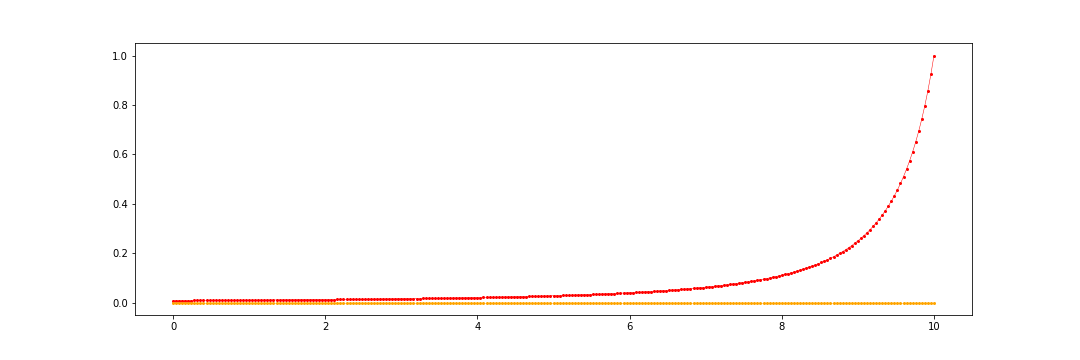

In [31]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,1,1)
ax0.plot(t, W_order1.real, marker='o', markersize=2, linewidth=0.5, color='red')
ax0.plot(t, W_order1.imag, marker='o', markersize=2, linewidth=0.5, color='orange')
plt.show()

### Order 2

In [32]:
u_list_p = []
u_list = []
v_list = []

nr_sample_edge = 250
delta_t = 10.0 / nr_sample_edge

for i_t1 in range(nr_sample_edge + 1):
    for i_t2 in range(nr_sample_edge + 1):
        times = np.array([delta_t * i_t1, delta_t * i_t2])
        times = np.sort(times)[::-1]
        u_list.append(times)
        v_list.append(k_imp.vi_from_ui(t_max, times))

g_order2_i = np.array(map(integrand, u_list))
g_order2_w = np.array(map(warper.evaluate_warping_function, u_list))

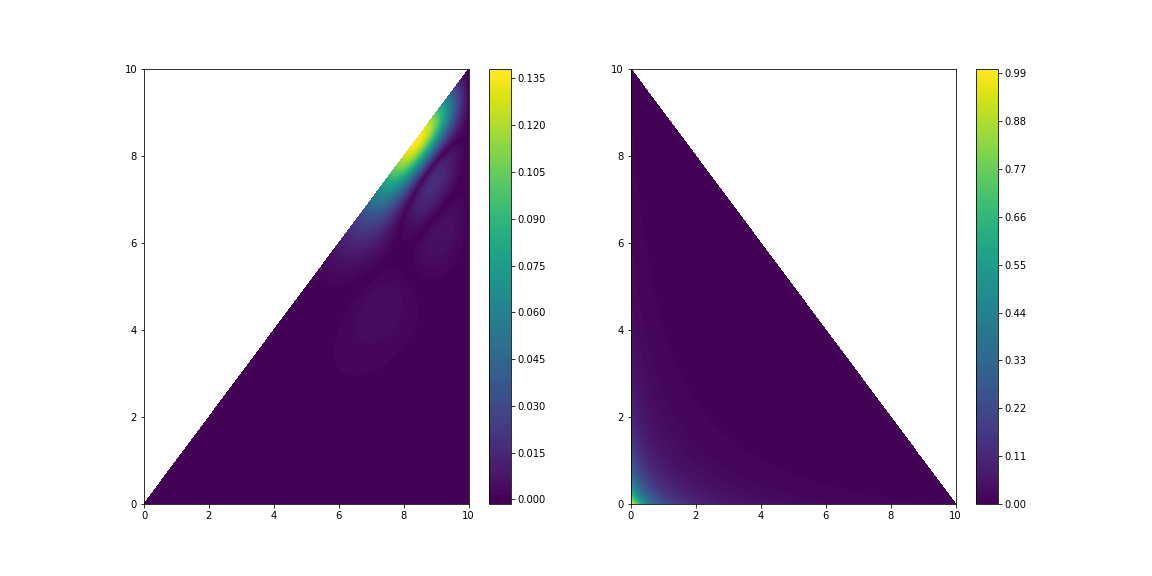

In [97]:
from scipy.interpolate import griddata

fig = plt.figure(figsize=(16,8))

x = np.array(u_list)[:,0]
y = np.array(u_list)[:,1]
z = np.abs(g_order2_i)

xi = np.linspace(0.0,10.0,500)
yi = np.linspace(0.0,10.0,500)
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

plt.subplot(1,2,1)
plt.contourf(xi,yi,zi, 100,vmin=z.min(), vmax=z.max())
plt.colorbar() # draw colorbar

x = np.array(v_list)[:,0]
y = np.array(v_list)[:,1]
z = np.abs(g_order2_w)

xi = np.linspace(0.0,10.0,500)
yi = np.linspace(0.0,10.0,500)
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

plt.subplot(1,2,2)
plt.contourf(xi,yi,zi, 100,vmin=z.min(), vmax=z.max())
plt.colorbar() # draw colorbar


plt.show()

In [46]:
# t = np.linspace(0.0,10.0,251)
# t_list = [list([t0, t0]) for t0 in t]

# W_order2_diag = np.array(map(computer.integrand, t_list))

# fig = plt.figure(figsize=(15,5))
# ax0 = plt.subplot(1,1,1)
# ax0.plot(t, W_order2_diag.real, marker='o', markersize=2, linewidth=0.5, color='red')
# ax0.plot(t, W_order2_diag.imag, marker='o', markersize=2, linewidth=0.5, color='orange')
# plt.show()

## SciPy Integral

In [47]:
def lim0():
    return [0, 10.0]

def lim1(t1):
    return [0, t1]

def lim2(t1, t2):
    return [0, t2]

result_1_sp = sp.integrate.nquad(lambda x: computer.integrand([x]).real, [lim0], opts={'limit': 1000}, full_output=True)
result_2_sp = sp.integrate.nquad(lambda x, y: computer.integrand([x, y]).imag, [lim1, lim0], opts={'limit': 1000}, full_output=True)
# result_3_sp = sp.integrate.nquad(lambda x, y, z: my_integrand([x, y, z]).real, [lim2, lim1, lim0], opts={'limit': 50}, full_output=True)


In [48]:
print "Order 1:", result_1_sp
print "Order 2:", result_2_sp

Order 1: (-0.18157328685641913, 2.3575981097923027e-09, {'neval': 63})
Order 2: (1.6315647010411563, 1.4869438519640528e-08, {'neval': 4893})


In [49]:
print result_1 + result_1_sp[0]
print result_2 + result_2_sp[0]

NameError: name 'result_1' is not defined

In [50]:
## Cuba Evaluation

### Cubature Evaulation

In [52]:
from cubature import cubature# S.Johnson package # https://github.com/saullocastro/cubature

In [185]:
#Order 1

def order_1_vectorize(t):
    t_list = [list(t0) for t0 in t]
    out = np.transpose(np.array([map(computer.integrand, t_list)]))
    return np.real(out[:,0])

xmin = [ 0.0]
xmax = [10.0 - 1e-10]
result_1_cub_val, result_1_cub_err = cubature(order_1_vectorize, 1, 1, xmin, xmax, vectorized=True, abserr=1e-10, relerr=1e-10, adaptive='p')
print result_1_cub_val[0], ",", result_1_cub_err[0]

-0.3780374601590787 , 1.0386247417670802e-11


In [186]:
print result_1 + result_1_cub_val[0]

5.5573594670565996e-08


In [ ]:
def my_integrand_order2_scaled(t):
    return t[0] * computer.integrand([t[0], t[0] * t[1]])


def order_2_scalar(t):
    t_list = [list(t0) for t0 in list(t)]
    out = np.imag(t[:, 0] * np.transpose(np.array([map(my_integrand_order2_scaled, t_list)])))
    return out[:,0]
#     return np.imag(t[0] * my_integrand([t[0], t[0] * t[1]]))

xmin = [0.0, 0.0]
xmax = [10.0, 1.0]
result_2_cub_val, result_2_cub_err = cubature(order_2_scalar, 2, 1, xmin, xmax, vectorized=True, abserr=1e-4, relerr=1e-4, adaptive='p')
print result_2_cub_val[0], ",", result_2_cub_err[0]

In [ ]:
print result_2 + result_2_cub_val[0]

In [48]:
def integrand_rectangle(x_array):
    return 1.

def integrand_rectangle_v(x_array):
    return np.ones_like(x_array[:, 0])

def integrand_circle(x_array):
    return x_array[0]

def integrand_circle_v(x_array):
    return x_array[:, 0]

def exact_rectangle(a, b):
    return a*b

def exact_circle(r):
    return math.pi*r**2

# rectangle
print('_________________')
print('')
print('Rectangle')
a, b = 3, 5
xmin = [0, 0]
xmax = [a, b]
val, err = cubature(integrand_rectangle, 2, 1, xmin, xmax)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_rectangle(a, b)))
# rectangle (vectorized)
print('_________________')
print('')
print('Rectangle (vectorized)')
a, b = 3, 5
xmin = [0, 0]
xmax = [a, b]
val, err = cubature(integrand_rectangle_v, 2, 1, xmin, xmax, vectorized=True)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_rectangle(a, b)))
# circle
print('_________________')
print('')
print('Circle')
r = 3.
xmin = [0, 0]
xmax = [r, 2*math.pi]
val, err = cubature(integrand_circle, 2, 1, xmin, xmax)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_circle(r)))
print('_________________')
# circle (vectorized)
print('_________________')
print('')
print('Circle (vectorized)')
r = 3.
xmin = [0, 0]
xmax = [r, 2*math.pi]
val, err = cubature(integrand_circle_v, 2, 1, xmin, xmax, vectorized=True)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_circle(r)))
print('_________________')


_________________

Rectangle


NameError: name 'cubature' is not defined

## Factorial vs Power Nr of Operations

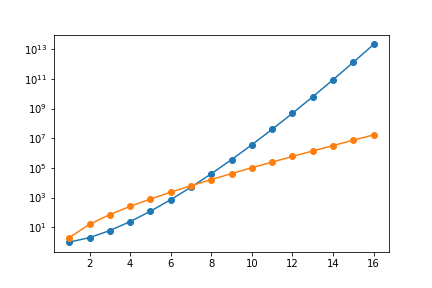

In [17]:
## Figure out exact FLOP scaling

x = np.linspace(1,16,16, dtype=int)
y_fac = map(np.math.factorial, x)#.linspace(1,10,10, dtype=int)
y_det = np.power(2, x) * np.square(x)

plt.plot(x, y_fac, marker='o')
plt.plot(x, y_det,  marker='o')
plt.yscale('log')

In [134]:
1+1

2

## Kernel

In [11]:
order = 2
computer = k_imp.ComputeGfKernel(anderson_param_A1, 10.0, order, 'first_order', int(1e6))
N_tot = 0

In [12]:
integrand = computer.get_integrand()
warper = computer.get_warper()

In [40]:
kernel_binner = k_imp.KernelBinner()

In [63]:
out = integrand([9,8])

In [64]:
for idx, val in out.data:
    print(print_gf_idx(idx), val)

((9.0, 'keldysh_idx_t::forward', 'spin_t::up'), (-0.020417622838676944+0.1313820602052629j))
((8.0, 'keldysh_idx_t::forward', 'spin_t::up'), (-0.006087787779146454-0.013749606056776506j))
((9.0, 'keldysh_idx_t::backward', 'spin_t::up'), (-0.11486525802082717-0.06055205597646656j))
((8.0, 'keldysh_idx_t::forward', 'spin_t::up'), (0.07842403242249744-0.1045779151288492j))
((9.0, 'keldysh_idx_t::forward', 'spin_t::up'), (0.06285291184605431+0.05033211223959197j))
((8.0, 'keldysh_idx_t::backward', 'spin_t::up'), (0.06480395688490563-0.02958809362292085j))
((9.0, 'keldysh_idx_t::backward', 'spin_t::up'), (0.07242996896801661+0.020497892077157458j))
((8.0, 'keldysh_idx_t::backward', 'spin_t::up'), (0.007532287705813379+0.1479156148407847j))


In [74]:
  np.abs((-0.020417622838676944+0.1313820602052629j) + (0.06285291184605431+0.05033211223959197j)) + np.abs((-0.006087787779146454-0.013749606056776506j) + (0.07842403242249744-0.1045779151288492j)) + np.abs((0.06480395688490563-0.02958809362292085j) + (0.007532287705813379+0.1479156148407847j)) + np.abs( (-0.11486525802082717-0.06055205597646656j) + (0.07242996896801661+0.020497892077157458j))


0.5223293771041537

In [66]:
abs((-0.020417622838676944+0.1313820602052629j) + (0.06285291184605431+0.05033211223959197j))

0.1866033070994673

In [56]:
(-0.006087787779146454-0.013749606056776506j) + (0.07842403242249744-0.1045779151288492j)

(0.07233624464335099-0.11832752118562571j)

In [58]:
(0.06480395688490563-0.02958809362292085j) + (0.007532287705813379+0.1479156148407847j)

(0.07233624459071901+0.11832752121786384j)

In [59]:
(-0.11486525802082717-0.06055205597646656j) + (0.07242996896801661+0.020497892077157458j)

(-0.04243528905281056-0.0400541638993091j)

In [33]:
def print_gf_idx(self):
    return self.time, self.k_idx, self.spin
